In [2]:
!pip install -Uqq fastai
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

import torch
torch.cuda.manual_seed_all(7)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
from fastai.vision.all import aug_transforms

tfms = aug_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.3, max_warp=0.3, max_rotate=20., max_zoom=0.05)

print(len(tfms))  # Should print the number of transformations


2


In [5]:
from fastai.vision.all import *

path = Path('breast_cancer_data')

# Function to get labels from last folder (0 or 1)
def get_label(f):
    return f.parent.name  # Extracts '0' or '1'

# Collect image files from all subdirectories
image_files = get_image_files(path)
print(f"Total images found: {len(image_files)}")

# Debug: Print first 10 image paths and labels
for f in image_files[:10]:
    print(f, "->", f.parent.name)  # Should print '0' or '1'

# Define DataBlock
breast_cancer_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=Resize(48),
    batch_tfms=[*aug_transforms(do_flip=True, flip_vert=True,
                                max_lighting=0.3, max_warp=0.3,
                                max_rotate=20., max_zoom=0.05),
                Normalize.from_stats(*imagenet_stats)]  # Normalize here
)

# Create DataLoader
data = breast_cancer_db.dataloaders(path, bs=128)


Total images found: 277524
breast_cancer_data/10253/0/10253_idx5_x1001_y1001_class0.png -> 0
breast_cancer_data/10253/0/10253_idx5_x1001_y1051_class0.png -> 0
breast_cancer_data/10253/0/10253_idx5_x1001_y1101_class0.png -> 0
breast_cancer_data/10253/0/10253_idx5_x1001_y1151_class0.png -> 0
breast_cancer_data/10253/0/10253_idx5_x1001_y1201_class0.png -> 0
breast_cancer_data/10253/0/10253_idx5_x1001_y1251_class0.png -> 0
breast_cancer_data/10253/0/10253_idx5_x1001_y1301_class0.png -> 0
breast_cancer_data/10253/0/10253_idx5_x1001_y1351_class0.png -> 0
breast_cancer_data/10253/0/10253_idx5_x1001_y1501_class0.png -> 0
breast_cancer_data/10253/0/10253_idx5_x1001_y1551_class0.png -> 0


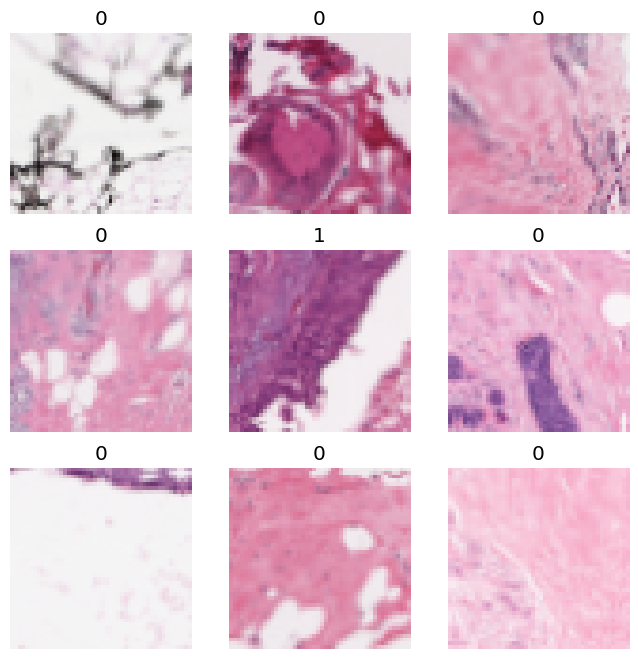

In [6]:
# Show sample images
data.show_batch(max_n=9, figsize=(8,8))


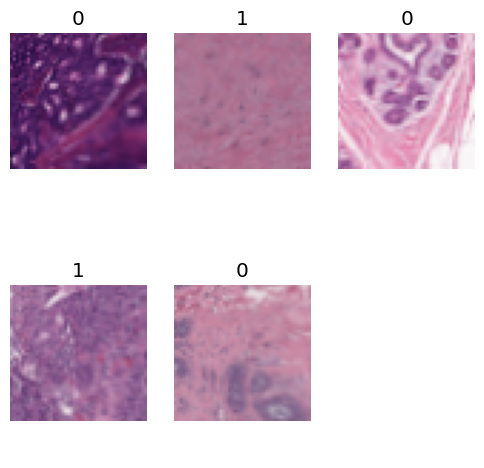

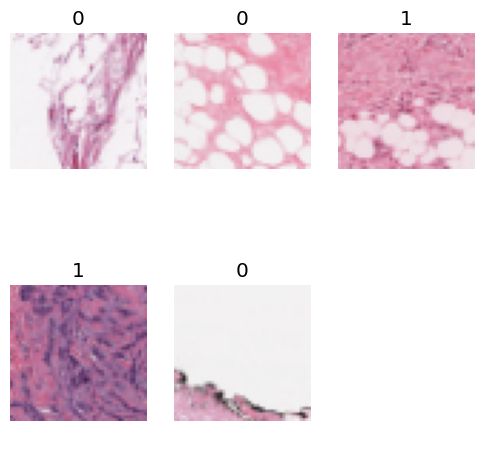

In [6]:
# Check class distributions
data.train.show_batch(max_n=5, figsize=(6,6))  # Show training images
data.valid.show_batch(max_n=5, figsize=(6,6))  # Show validation images


In [7]:
from collections import Counter

In [8]:
# Extract labels from train set
train_labels = [data.train_ds.items[i].parent.name for i in range(len(data.train_ds))]
train_counts = Counter(train_labels)
print("Training label counts:", train_counts.most_common())

# Extract labels from validation set
valid_labels = [data.valid_ds.items[i].parent.name for i in range(len(data.valid_ds))]
valid_counts = Counter(valid_labels)
print("Validation label counts:", valid_counts.most_common())


Training label counts: [('0', 159045), ('1', 62975)]
Validation label counts: [('0', 39693), ('1', 15811)]


In [9]:
# Initializing the custom class weights
import torch
weights = [0.4, 1]
class_weights = torch.FloatTensor(weights)  # Remove .cuda()


breast_cancer_data
Using device: cpu


['0', '1'] 2


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.436715,0.391189,0.822157,50:24
1,0.395170,0.351806,0.850497,37:13
2,0.381021,0.343426,0.846065,36:04
3,0.345856,0.329735,0.858082,38:21
4,0.356296,0.340325,0.856497,39:40


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

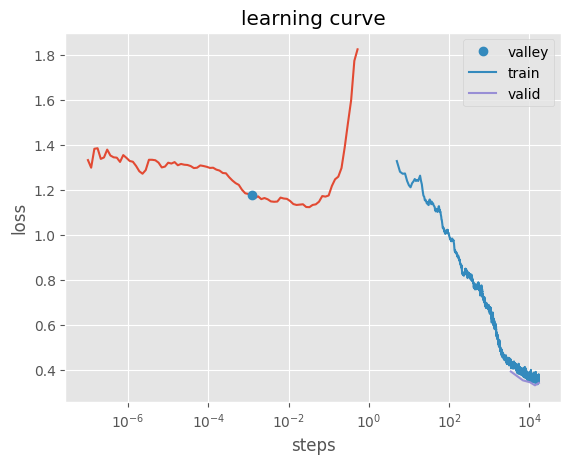

In [10]:
from fastai.vision.all import *
import torch
from torch import nn

print(path)
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define class weights
class_weights = torch.FloatTensor([0.4, 1]).to(device)

# Define DataBlock
breast_cancer_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda x: x.parent.name,
    item_tfms=Resize(48),
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True,
                              max_lighting=0.3, max_warp=0.3,
                              max_rotate=20., max_zoom=0.05)
)

# Create DataLoaders with lower batch size
data = breast_cancer_db.dataloaders(path, bs=64)  # Lower batch size for stability

# Check data
print(data.vocab, data.c)  # Ensure correct labels and class count

# Initialize ResNet-50 Learner
learn = cnn_learner(data, models.resnet50, metrics=accuracy).to_fp16()

# Assign Weighted Loss Function
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)

# Find best learning rate separately
learn.lr_find()
# Manually set lr_max based on lr_find() output
lr_max = 1e-3  # Adjust based on lr_find curve

# Train using One-Cycle Policy
learn.fit_one_cycle(5, lr_max=lr_max)

# Plot Losses
learn.recorder.plot_loss()


In [11]:
    # Saving the model
learn.save('stage-1-rn50-with-high-accuracy')

Path('models/stage-1-rn50-with-high-accuracy.pth')

In [12]:
# Model's final training loss and accuracy
train_loss = learn.validate(dl=learn.dls.train)

# Model's final validation loss and accuracy
valid_loss = learn.validate(dl=learn.dls.valid)

print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {valid_loss}")


Training Loss: [0.39316847920417786, 0.860037088394165]
Validation Loss: [0.34032508730888367, 0.8564968109130859]


In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [17]:
print(f"Total misclassified samples: {len(interp.top_losses()[0])}")


Total misclassified samples: 55504


In [22]:
b = learn.dls.valid.one_batch()
decoded_batch = learn.dls.valid.decode(b)

print("Decoded Batch Example:", decoded_batch)


Decoded Batch Example: (TensorImage([[[[246, 247, 247,  ..., 240, 205, 229],
               [247, 247, 247,  ..., 238, 207, 243],
               [247, 246, 246,  ..., 199, 196, 241],
               ...,
               [246, 246, 247,  ..., 245, 245, 243],
               [247, 247, 246,  ..., 245, 245, 243],
               [247, 247, 246,  ..., 246, 245, 245]],

              [[245, 245, 245,  ..., 227, 153, 214],
               [245, 245, 245,  ..., 220, 147, 229],
               [245, 245, 245,  ..., 152, 122, 230],
               ...,
               [245, 245, 245,  ..., 239, 238, 228],
               [245, 245, 245,  ..., 241, 239, 241],
               [245, 245, 245,  ..., 239, 239, 240]],

              [[245, 246, 246,  ..., 230, 175, 225],
               [245, 245, 245,  ..., 227, 173, 233],
               [245, 245, 245,  ..., 174, 154, 233],
               ...,
               [245, 244, 245,  ..., 240, 239, 232],
               [245, 244, 244,  ..., 244, 241, 237],
           

In [23]:
print(len(interp.losses))


55504


In [30]:
preds, targs, decoded = learn.get_preds(dl=learn.dls.valid, with_decoded=True, with_targs=True)
print(f"Predictions shape: {preds.shape}")
print(f"Targets shape: {targs.shape}")
print(f"Decoded shape: {decoded.shape}")


Predictions shape: torch.Size([55504, 2])
Targets shape: torch.Size([55504])
Decoded shape: torch.Size([55504, 2])


In [31]:
print(f"Validation DataLoader size: {len(learn.dls.valid)}")


Validation DataLoader size: 868


In [33]:
min_len = min(len(preds), len(targs))
preds, targs = preds[:min_len], targs[:min_len]


In [45]:
from sklearn.metrics import classification_report

def return_classification_report(learn):
    # Get predictions from the validation set
    results = learn.get_preds(dl=learn.dls.valid, with_decoded=True)

    # Check the number of returned values
    if len(results) == 2:
        preds, targs = results  # Expected case
    elif len(results) == 3:
        preds, targs, _ = results  # Handle extra returned loss values
    else:
        raise ValueError(f"Unexpected number of return values: {len(results)}")

    # Convert tensor predictions to class labels
    vocab = learn.dls.vocab  # Get class names
    pred_labels = [vocab[p] for p in preds.argmax(dim=1).numpy()]
    ground_truth = [vocab[t] for t in targs.numpy()]

    assert len(pred_labels) == len(ground_truth)

    return classification_report(ground_truth, pred_labels, target_names=vocab)

# Print classification report
print(return_classification_report(learn))


              precision    recall  f1-score   support

           0       0.94      0.85      0.89     39693
           1       0.70      0.88      0.78     15811

    accuracy                           0.86     55504
   macro avg       0.82      0.86      0.84     55504
weighted avg       0.87      0.86      0.86     55504



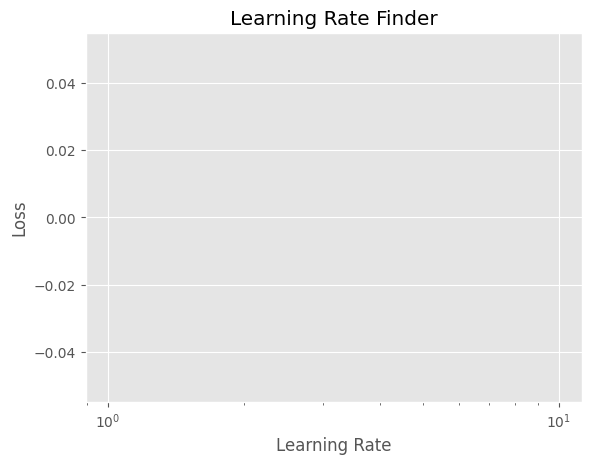

In [46]:
import matplotlib.pyplot as plt

lrs = learn.recorder.lrs
losses = learn.recorder.losses

plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.show()


In [49]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-4, 1e-5))
learn.save('stage-2-more-rn50-high-accuracy')


epoch,train_loss,valid_loss,accuracy,time
0,0.350601,0.317755,0.858317,54:04
1,0.317729,0.310668,0.869811,51:41


Path('models/stage-2-more-rn50-high-accuracy.pth')

In [50]:
# Looking at the classification report
print(return_classification_report(learn))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     39693
           1       0.72      0.89      0.80     15811

    accuracy                           0.87     55504
   macro avg       0.84      0.88      0.85     55504
weighted avg       0.89      0.87      0.87     55504



In [53]:
!pip install seaborn

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


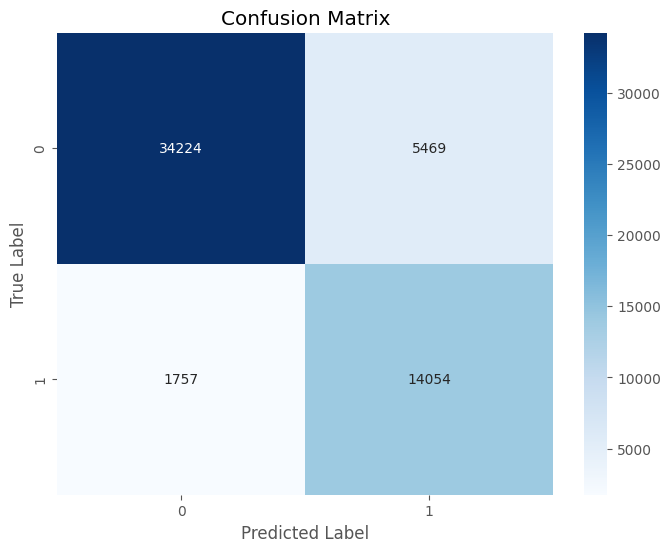

In [57]:
from fastai.vision.all import *
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions correctly
preds, targs = learn.get_preds(dl=learn.dls.valid)
preds_classes = preds.argmax(dim=1)  # Convert logits to class predictions

# Compute confusion matrix
cm = confusion_matrix(targs, preds_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.vocab, yticklabels=data.vocab)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [51]:
learn.summary()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Sequential (Input shape: 64 x 3 x 48 x 48)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 24 x 24   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 12 x 12   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 12 x 12  
Conv2d                                    16384      True      
BatchNorm2d                          